Fitting 3 folds for each of 50 candidates, totalling 150 fits
Submission file saved at: C:\Users\HP\Downloads\submission_file.xlsx
Optimized XGBoost RMSE: 8481.9653
Optimized XGBoost R^2: 0.8101
Best Hyperparameters found by RandomizedSearchCV:
{'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 0.5, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 1.0}


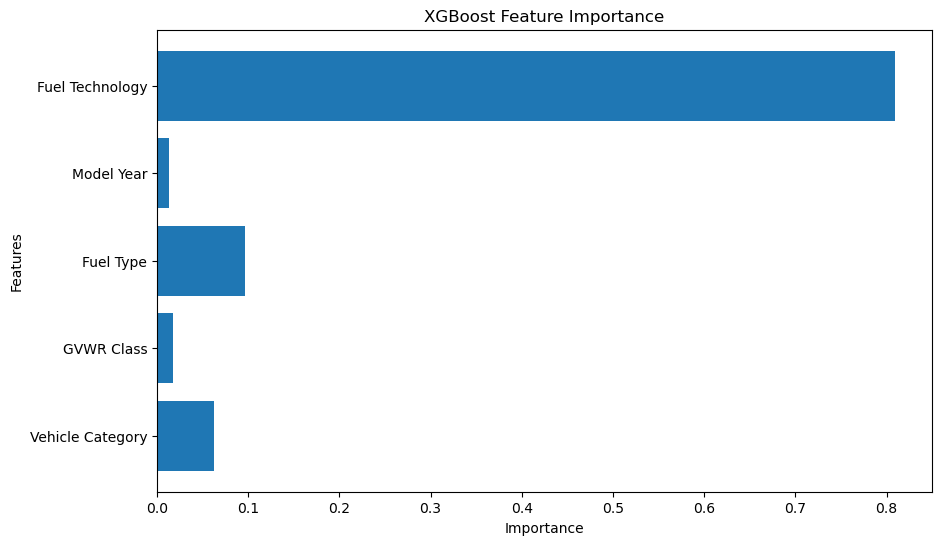

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

train_data = pd.read_excel(r'C:\Users\HP\Downloads\training.xlsx', sheet_name='Sheet1')
scoring_data = pd.read_excel(r'C:\Users\HP\Downloads\scoring.xlsx', sheet_name='Sheet1')

features = ['Vehicle Category', 'GVWR Class', 'Fuel Type', 'Model Year', 'Fuel Technology']
target = 'Vehicle Population'

def clean_column(data, column_name):
    data[column_name] = data[column_name].astype(str)
    
    data[column_name] = data[column_name].fillna('Unknown')

columns_to_encode = ['Vehicle Category', 'GVWR Class', 'Fuel Type', 'Fuel Technology']

label_encoder = LabelEncoder()

for col in columns_to_encode:
    clean_column(train_data, col)
    clean_column(scoring_data, col)
    
    train_data[col] = label_encoder.fit_transform(train_data[col])
    scoring_data[col] = label_encoder.transform(scoring_data[col])  # Use the same encoder for scoring data

X_train = train_data[features]
y_train = train_data[target]
X_test = scoring_data[features]
y_test = scoring_data[target]

param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],
}

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

randomized_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, 
                                       n_iter=50, cv=3, n_jobs=-1, random_state=42, verbose=2, 
                                       scoring='neg_mean_squared_error')

randomized_search.fit(X_train, y_train)

best_xgb_model = randomized_search.best_estimator_

y_pred = best_xgb_model.predict(X_test)

submission_file = pd.read_excel(r'C:\Users\HP\Downloads\submission_file.xlsx', sheet_name='Sheet1')
submission_file['Vehicle Population'] = y_pred

submission_file_path = r'C:\Users\HP\Downloads\submission_file.xlsx'
submission_file.to_excel(submission_file_path, index=False)

print(f"Submission file saved at: {submission_file_path}")

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Optimized XGBoost RMSE: {rmse:.4f}")
print(f"Optimized XGBoost R^2: {r2:.4f}")

print("Best Hyperparameters found by RandomizedSearchCV:")
print(randomized_search.best_params_)

plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, best_xgb_model.feature_importances_)
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()